# Assignment 01

This assignment consists of two tasks with subtasks. Every subtask has a point value and lists expectations for answers. Please read both task and expectations carefully before answering.

### Hand-in Instructions

Submit a single `.ipynb` file with all outputs saved. The notebook must be fully self-contained and ready to read without running any cells.

### Overview

| Task  | Topic                                     | Points  |
| ----- | ----------------------------------------- | ------- |
| **1** | **PCA**                                   |         |
| 1.1   | 3D scatter plot                           | 5       |
| 1.2   | 2D scatter plot                           | 5       |
| 1.3   | Interpreting variance                     | 10      |
| 1.4   | Variance and geometry                     | 10      |
| **2** | **Breast Cancer Classification Pipeline** |         |
| 2.1   | Exploratory Data Analysis                 | 30      |
| 2.2   | Train/Test Split                          | 5       |
| 2.3   | Baseline Model                            | 5       |
| 2.4   | Kitchen Sink Model                        | 10      |
| 2.5   | Build Your Own Pipeline                   | 20      |
|       | **Total**                                 | **100** |


---

## Setup


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import load_breast_cancer


from assignment_utils import generate_annulus_4d

---

## Task 1: PCA

You've been given a mysterious dataset with **4 dimensions** (F1, F2, F3, F4). We can't directly visualize 4D data, but we can look at 3 dimensions at a time and use color for the 4th.


In [ ]:
data_4d, radius = generate_annulus_4d()
df = pd.DataFrame(data_4d, columns=["F1", "F2", "F3", "F4"])
print(f"Dataset shape: {df.shape}")

# Let's visualize the first 3 dimensions (F1, F2, F3) in 3D
# The 4th dimension (F4) is represented as color
fig = px.scatter_3d(
    df,
    x="F1",
    y="F2",
    z="F3",
    color=df["F4"],
    color_continuous_scale="viridis",
    title="3D View of the 4D Dataset (F1, F2, F3, color=F4)",
    labels={"color": "F4"},
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(width=800, height=600)
fig.show()

### Principal Component Analysis (PCA)

**PCA** is a technique that finds new axes (called _principal components_) that capture the most variance in the data.

**Mathematical formulation:**

1. **Standardize** the data: $\mathbf{Z} = \frac{\mathbf{X} - \boldsymbol{\mu}}{\boldsymbol{\sigma}}$

2. Compute the **covariance matrix**: $\mathbf{C} = \frac{1}{n-1} \mathbf{Z}^T \mathbf{Z}$

3. Find the **eigenvectors** and **eigenvalues** of $\mathbf{C}$:
   $$\mathbf{C} \mathbf{v}_i = \lambda_i \mathbf{v}_i$$
4. **Project** the data onto the principal components: $\mathbf{Z}_{PC} = \mathbf{Z} \mathbf{V}$

where $\mathbf{V} = [\mathbf{v}_1, \mathbf{v}_2, \ldots]$ are the eigenvectors sorted by decreasing eigenvalue $\lambda_i$.

**Key ideas:**

- **PC1** points in the direction of maximum variance (largest $\lambda$)
- **PC2** is perpendicular to PC1 and captures the next most variance
- The **explained variance ratio** for each PC is: $\frac{\lambda_i}{\sum_j \lambda_j}$
- The eigenvectors $\mathbf{V} = [\mathbf{v}_1, \mathbf{v}_2, \ldots]$ are basis vectors for the principal component space. Any data vector can be completely reconstructed by a linear combination of these principal component basis vectors.

If the data lies on a lower-dimensional subspace, PCA can reveal it by finding the directions that matter most.

Let's standardize the data first (so all features have equal scale), then apply PCA.


In [ ]:
# Standardize and apply PCA
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

pca = PCA()
data_pca = pca.fit_transform(data_scaled)

# Create a DataFrame with principal components
df_pca = pd.DataFrame(data_pca, columns=["PC1", "PC2", "PC3", "PC4"])
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance ratio:", np.cumsum(pca.explained_variance_ratio_))

# Get the PC directions (loadings) - each row is a PC, each column is a feature
components = pca.components_  # Shape: (4, 4) - 4 PCs x 4 features

# Create the scatter plot of scaled data (first 3 features)
fig = go.Figure()

# Add the data points
fig.add_trace(
    go.Scatter3d(
        x=data_scaled[:, 0],
        y=data_scaled[:, 1],
        z=data_scaled[:, 2],
        mode="markers",
        marker=dict(size=2, opacity=0.5),
        name="Data",
    )
)

# Add arrows for PC1, PC2, PC3 directions
# Arrow length proportional to explained variance ratio (with minimum for visibility)
colors = ["red", "green", "blue"]
base_scale = 5  # Base scale factor
min_scale = 0.5  # Minimum scale so small PCs are still visible

for i in range(3):
    pc_direction = components[i, :3]  # First 3 components of each PC
    # Scale by explained variance ratio - longer arrow = more variance
    # Use minimum scale so all arrows are visible
    variance_ratio = pca.explained_variance_ratio_[i] / max(
        pca.explained_variance_ratio_
    )
    scale = max(base_scale * variance_ratio, min_scale)

    # Arrow line
    fig.add_trace(
        go.Scatter3d(
            x=[0, pc_direction[0] * scale],
            y=[0, pc_direction[1] * scale],
            z=[0, pc_direction[2] * scale],
            mode="lines",
            line=dict(color=colors[i], width=8),
            name=f"PC{i + 1} ({pca.explained_variance_ratio_[i]:.1%} var)",
        )
    )

    # Arrow head (cone)
    fig.add_trace(
        go.Cone(
            x=[pc_direction[0] * scale],
            y=[pc_direction[1] * scale],
            z=[pc_direction[2] * scale],
            u=[pc_direction[0]],
            v=[pc_direction[1]],
            w=[pc_direction[2]],
            colorscale=[[0, colors[i]], [1, colors[i]]],
            showscale=False,
            sizemode="absolute",
            sizeref=0.3,
        )
    )

fig.update_layout(
    title="Principal Component Directions (arrow length ∝ variance explained)",
    scene=dict(
        xaxis_title="F1 (scaled)",
        yaxis_title="F2 (scaled)",
        zaxis_title="F3 (scaled)",
    ),
    width=800,
    height=600,
)
fig.show()

### Task 1.1 3D scatter plot

- Task: Create a 3D scatter plot using PC1, PC2, PC3 as axes
- Points: 5
- Expectations: A working 3D scatter plot of the PCA-transformed data (similar in style to the first 3D plot). No further analysis or comments.


In [ ]:
# Your code here
fig = px.scatter_3d(
    df_pca,
    x="PC1",
    y="PC2",
    z="PC3",
    color=df_pca["PC4"],
    color_continuous_scale="viridis",
    title="3D PCA Projectrion (color = PC4)",
    labels={"color": "F4"},
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(width=800, height=600)
fig.show()

### Task 1.2 2D scatter plot

- Task: Create a 2D scatter plot using PC1, PC2 as axes
- Points: 5
- Expectations: A working 2D scatter plot of the PCA-transformed data. No further analysis or comments.


In [ ]:
# Your code here

# Test to see what data we have
# print(df.columns.tolist())
# print(df.shape)

fig = px.scatter(
    df_pca,
    x="PC1",
    y="PC2",
    color="PC4",
    hover_data=["PC3", "PC4"],
    color_continuous_scale="viridis",
    title="2D PCA Projection (x=PC1, y=PC2, hover=PC3, color=PC4)",
    labels={"color": "PC4"},
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(width=800, height=600)
fig.show()

### Task 1.3 Interpreting variance

- Task: How much variance do PC1 and PC2 capture together? Based on this, what can you conclude about the original 4D dataset?
- Points: 10
- Expectations: A written response (1 paragraph).


#### Answer


PC1Var = 50.9%
PC2Var = 49.1%

SumVar = PC1Var + PC2Var = 50.9% + 49.1% = 100%. This means that of the original 4D dataset PC1 and PC2 contains all the information while the other two don't contribute meaningfully to the dataset.


### Task 1.4 Variance and geometry

- Task: If PC1 explained 90% of the variance and PC2 only 10%, what shape would you expect the data to form? Now compare this to your actual ~50/50 split — what does this tell you about the geometry of your data?
- Points: 10
- Expectations: A written response (1 paragraph).


#### Answer


Since data variance is the measure of how far each data point is from the mean. A 90% variance in PC1 would make the vector showing variance longer. This would then stretch the circle in the direction and opposite direction of the vector making it an oval. Since the PC2 vector is now only 10% we would se a ratio between the "height" and "width" of the oval as close to 9:1, since there is 0,02 noise put into the assignment_utils.py file.


---

## Task 2: Breast Cancer Classification Pipeline

Now let's apply what you've learned to a real-world dataset: the **Wisconsin Breast Cancer** dataset. This dataset contains measurements from cell nuclei in breast tissue samples, and the goal is to classify tumors as **malignant** or **benign**.

**Sources:**

- [sklearn.datasets.load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)
- [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)

We'll work through a complete machine learning workflow:

1. Exploratory Data Analysis (EDA)
2. Train/test split
3. Baseline model
4. "Kitchen sink" model (all features, no preprocessing)
5. Build your own pipeline


In [ ]:
# Load the breast cancer dataset
cancer = load_breast_cancer()
df_cancer = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df_cancer["target"] = cancer.target

print(f"Dataset shape: {df_cancer.shape}")
print(f"Target classes: {cancer.target_names}")

### Task 2.1 Exploratory Data Analysis (EDA)

- Task: Conduct an EDA of the breast cancer dataset. For each analysis you perform, explain _why_ you chose to look at it and what it tells you.
- Points: 30
- Expectations: A mix of code, plots, and written commentary. Quality of reasoning and plots matters more than quantity of plots.


In [ ]:
df_cancer.head()

From the first five rows, we can see that the dataset contains numeric values for all features, and that the target column has been added correctly. This gives us an initial sense of the data, but we cannot yet confirm the data types or whether there are missing values.


Next, we use info() to check data types and missing values. This is a nice step to do because it informs us whether preprocessing steps like imputation or type conversion are required before modeling:


In [ ]:
df_cancer.info()

From the info() output, we can confirm that all feature columns are numeric (float64), the target column is an integer type (int64), and there are no missing values. This means the dataset is clean and no immediate data cleaning is necessary.


We then examine the class distribution using value_counts() to assess potential imbalance. Class imbalance can affect the baseline accuracy and the choice of evaluation metrics, as models can become biased toward the majority class:


In [ ]:
df_cancer["target"].value_counts()

The output shows that benign tumors are more common than malignant tumors, indicating a moderate class imbalance. This suggests that accuracy alone may be misleading, and we should use relative comparisons to ensure we avoid any bias.


Next, we inspect the feature scales and spread using descriptive statistics. This step is important because many machine learning models are sensitive to the magnitude of input features:


In [ ]:
df_cancer.drop(columns="target").describe().T

The summary reveals that some features have values close to zero while others reach the hundreds or thousands. This confirms the need for standardization before applying models that are scale-sensitive, such as logistic regression, SVMs, or PCA.


To identify which features are most informative for separating malignant and benign tumors, we compute the correlation of each feature with the target:


In [ ]:
target_corr = (
    df_cancer.corr()["target"].drop("target").abs().sort_values(ascending=False)
)
fig = px.bar(
    target_corr,
    title="Absolute Correlation of Features with Target",
    labels={"index": "Feature", "value": "Absolute Correlation"},
)
fig.show()

This shows which features are most strongly associated with the target. However, some of the top-correlated features might be highly correlated with each other, which would introduce redundancy if plotted all together.


To select a small set of diverse, informative features, we calculate the feature-feature correlation matrix and iteratively pick top target-correlated features while avoiding those that are highly correlated with already-selected features (threshold > 0.9):


In [ ]:
feature_corr = df_cancer.drop(columns="target").corr().abs()

top_features = []
threshold = 0.9
sorted_features = target_corr.index.tolist()

for feature in sorted_features:
    if all(feature_corr[feature][f] < threshold for f in top_features):
        top_features.append(feature)
    if len(top_features) >= 3:
        break

print("Selected features for distribution plots:", top_features)
for feature in top_features:
    fig = px.box(
        df_cancer,
        x="target",
        y=feature,
        points="all",
        title=f"{feature} Distribution by Target (0 = Malignant, 1 = Benign)",
    )
    fig.show()

fig = px.scatter_3d(
    df_cancer,
    x=top_features[0],
    y=top_features[1],
    z=top_features[2],
    color="target",
    title=f"3D Scatter of Top Features by Target",
    labels={"target": "Target"},
)

fig.update_traces(marker=dict(size=4, opacity=0.7))
fig.show()

This ensures that the features we visualize are both highly informative for the target and non-redundant, providing the clearest insights for class separation.


We now visualize the class-conditional distributions of the selected features using histograms:


In [ ]:
for feature in top_features:
    fig = px.histogram(
        df_cancer,
        x=feature,
        color="target",
        barmode="overlay",
        opacity=0.6,
        title=f"Distribution of {feature} by Target (0 = Malignant, 1 = Benign)",
    )
    fig.show()

From these plots, we observe that malignant tumors generally have larger values in these features, though some overlap exists. This indicates that these features are useful for classification, but the overlap shows that a simple threshold may not perfectly separate the classes.


Finally, we examine the correlations among all features using a heatmap to understand redundancy and relationships:


In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_cancer.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation")
plt.show()

The heatmap highlights strong correlations among related features, particularly among measurements of radius, perimeter, and area. This explains why we selected only a subset of features for the distribution plots and suggests that dimensionality reduction (PCA) or regularized models could be useful in downstream analysis.


### Task 2.2 Train/Test Split

- Task: Split the data into training and test sets (80/20) before any modeling.
- Points: 5
- Expectations: Complete the TODO line to create an 80/20 split with `random_state=42` for reproducibility.


In [ ]:
# Separate features and target
X = df_cancer.drop("target", axis=1)
y = df_cancer["target"]

# TODO: Split into train/test sets. Done
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Task 2.3 Baseline Model

Before building a real model, it's wise to establish a **baseline** — a classifier that any real model should beat.

A **confusion matrix** shows how predictions compare to actual labels:

|                     | Predicted Negative  | Predicted Positive  |
| ------------------- | ------------------- | ------------------- |
| **Actual Negative** | TN (True Negative)  | FP (False Positive) |
| **Actual Positive** | FN (False Negative) | TP (True Positive)  |

For cancer diagnosis: FN means missing a malignant tumor (bad!), FP means a false alarm (less bad, but still costly).

- Task: Run the code below, note the accuracy and examine the confusion matrix. Describe what this classifier does. Would you trust it for diagnosis? Why or why not?
- Points: 5
- Expectations: A written response (1 paragraph).


In [ ]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

baseline_accuracy = dummy.score(X_test, y_test)
print(f"Baseline accuracy: {baseline_accuracy:.3f}")

ConfusionMatrixDisplay.from_estimator(
    dummy, X_test, y_test, display_labels=cancer.target_names, cmap="Blues"
)
plt.title("Confusion Matrix: Baseline Model")
plt.show()

#### Answer


Markdown accuracy is 62,3% which by itself would disqualify this model from being used in diagnosis of cancer in patients since its lower than the average for clinical professionals (https://pmc.ncbi.nlm.nih.gov/articles/PMC12047852/). The model uses whatever the highest true label is and categorizes all other predictions in the same category, predicted label: benign since true label: benign is most likely. This is quite frankly an idiotic way of doing it, since in this data set you are guaranteed to get FN's which is verry bad, or the other way around. People who don't actually have cancer get diagnosed with it in 100% of cases where they don't. The way it classifies cases doesn't allow it to change the guesses it makes unless the true label: malignant > true label: benign, which is highly unlikely to happen. This also disqualifies this model from being used. In short I wouldn't trust it.


### Task 2.4 Kitchen Sink Model

The "kitchen sink" approach: throw all features into the model without any preprocessing. Let's see what happens.

**Logistic Regression** is a linear classifier that predicts the probability of a binary outcome. It models:

$$P(y=1 | \mathbf{x}) = \sigma(\mathbf{w}^T \mathbf{x} + b) = \frac{1}{1 + e^{-(\mathbf{w}^T \mathbf{x} + b)}}$$

where $\sigma$ is the sigmoid function, $\mathbf{w}$ are the feature weights, and $b$ is the bias. The model is trained by minimizing the logistic loss using an iterative optimizer. Here we use **SAGA** (`solver="saga"`), a stochastic gradient method whose fast convergence is only guaranteed on features with approximately the same scale ([sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).

- Task: Run the code below. Did the model converge? Why or why not? Explain based on your EDA findings and how gradient-based optimization works.
- Points: 10
- Expectations: A written response (1 paragraph).


Kitchen sink train accuracy: 0.899
Kitchen sink test accuracy:  0.947


/home/sbohmer/IntroKI/course-materials/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



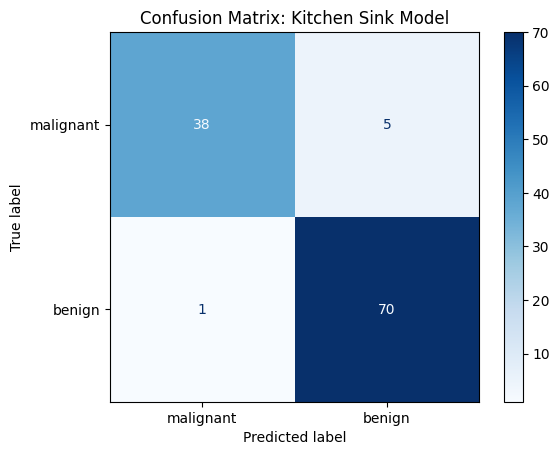

In [13]:
lr_kitchen = LogisticRegression(solver="saga", max_iter=100, random_state=42)
lr_kitchen.fit(X_train, y_train)

kitchen_train_accuracy = lr_kitchen.score(X_train, y_train)
kitchen_accuracy = lr_kitchen.score(X_test, y_test)
print(f"Kitchen sink train accuracy: {kitchen_train_accuracy:.3f}")
print(f"Kitchen sink test accuracy:  {kitchen_accuracy:.3f}")

ConfusionMatrixDisplay.from_estimator(
    lr_kitchen, X_test, y_test, display_labels=cancer.target_names, cmap="Blues"
)
plt.title("Confusion Matrix: Kitchen Sink Model")
plt.show()

#### Answer
The model did not converge as it hit the upper limit posed by max_iter. Since gradience-based optimisation works by taking small steps based on the "evenness" of it's slope to get to the bottom of the slope, if it has too few steps, too short steps, or too big steps it will not converge on the local optimal solution. Doing some brute force testing it needs max_iter at about 3825. But more importantly in the EDA we found out that there were significant divergencies in the scale of some features. As the model used requires aproximately equal scale, this is most probably undermining the results.


### Task 2.5 Build Your Own Pipeline

Now it's your turn. Based on your EDA findings, build a classification pipeline.

A **Pipeline** chains multiple preprocessing steps and a final estimator into a single object. This ensures:

- No data leakage (preprocessing is fit only on training data)
- Clean, reproducible code
- Easy experimentation with different configurations

Example pipeline structure:

```python
Pipeline([
    ("step1_name", SomeTransformer()),
    ("step2_name", AnotherTransformer()),
    ("classifier", SomeClassifier()),
])
```

- Task: Build a pipeline that preprocesses the data and fits a classifier. Evaluate your model, compare it to the kitchen sink model, and justify your preprocessing choices based on your EDA insights.
- Points: 20
- Notes:
  - You are free to use any preprocessing technique (e.g., StandardScaler, PCA, column selection via ColumnTransformer, or others)
  - There is no single "correct" answer — the goal is thoughtful justification
- Expectations:
  - A working pipeline with at least one preprocessing step
  - A confusion matrix plot for your model
  - A comparison with the kitchen sink model's confusion matrix
  - A reflection on your model's errors — consider which types of mistakes matter most in a medical diagnosis context (1 paragraph)
  - A brief explanation of why you chose your preprocessing steps (1 paragraph)
  - **NOTE:** Your understanding and evaluation of the model performance is the objective here. The model's performance (how well it accurately classifies the data) will not detract from your grade. So if your model doesn't perform well, but you can explain why it doesn't perform well, then you can still receive the full 20 points.


In [14]:
# TODO: Build your pipeline
# Consider: What preprocessing steps would help based on your EDA?
# Available transformers: StandardScaler, PCA, ColumnTransformer, etc.

# --- Pipeline model (Scaler + PCA + Logistic Regression) ---
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=10, random_state=42)),
        ("clf", LogisticRegression(solver="saga", max_iter=3000, random_state=42)),
    ]
)

### TODO: Fit the pipeline on training data
pipe.fit(X_train, y_train)


### TODO: Evaluate and print accuracy
pipe_train_accuracy = pipe.score(X_train, y_train)
pipe_test_accuracy = pipe.score(X_test, y_test)

print(f"Pipeline train accuracy: {pipe_train_accuracy:.3f}")
print(f"Pipeline test accuracy:  {pipe_test_accuracy:.3f}")


### TODO: Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(
    pipe, X_test, y_test, display_labels=cancer.target_names, cmap="Greens"
)
plt.title("Confusion Matrix: Pipeline Model (Scaler + PCA + LR)")
plt.show()

#### Discussion

The preprocessing steps used in the pipeline consisted of feature scaling using `StandardScaler` and dimensionality reduction using PCA. `StandardScaler` was applied to ensure that all features contributed equally to the model, while PCA was used to reduce redundancy among highly correlated features prior to fitting the logistic regression classifier.

PCA was configured to retain 10 components in order to reduce dimensionality while preserving most of the variance in the original feature space. Based on the EDA, several features exhibited strong correlations, indicating redundancy in the dataset. Reducing the feature space to 10 principal components allows the model to capture the most informative structure in the data while mitigating noise and multicollinearity, resulting in a more stable logistic regression model.

All preprocessing steps were implemented within a scikit-learn Pipeline to prevent data leakage. By fitting the scaler and PCA exclusively on the training data and subsequently applying the learned transformations to the test data, the evaluation more accurately reflects how the model would perform on unseen patients. This ensures that no information from the test set influences either preprocessing or model training.
